# ANUGA - Time varying topo example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

%matplotlib inline
import anuga

In [2]:
name = 'channel_variable_bed_0.2_newviewer'

## Setup the simulation

In [3]:
from anuga import rectangular_cross
from anuga import Domain
from anuga import Reflective_boundary
from anuga import Dirichlet_boundary
from anuga import Time_boundary

Computational domain

In [4]:
length = 24.
width = 5.
dx = dy = 0.2 #.1           # Resolution: Length of subdivisions on both axes

points, vertices, boundary = rectangular_cross(int(length/dx), int(width/dy),
                                               len1=length, len2=width)
domain = Domain(points, vertices, boundary)
domain.set_name('channel_variable_bed_0.2_newviewer') # Output name
print domain.statistics()
#domain.set_quantities_to_be_stored({'elevation': 2, 'stage': 2})

In [5]:
domain.set_quantities_to_be_stored?

Initial condition

In [6]:
def topography(x,y):
    """Complex topography defined by a function of vectors x and y."""

    z = -x/100
    
    N = len(x)
    for i in range(N):
        # Step
        if 2 < x[i] < 4:
            z[i] += 0.4 - 0.05*y[i]
    
        # Permanent pole
        if (x[i] - 8)**2 + (y[i] - 2)**2 < 0.4**2:
            z[i] += 1
    return z
    

def pole_increment(x,y):
    """This provides a small increment to a pole located mid stream
    For use with variable elevation data
    """
    
    z = 0.0*x

    N = len(x)
    for i in range(N):
        # Pole 1
        if (x[i] - 12)**2 + (y[i] - 3)**2 < 0.4**2:
            z[i] += 0.01
            
    for i in range(N):
        # Pole 2
        if (x[i] - 14)**2 + (y[i] - 2)**2 < 0.4**2:
            z[i] += 0.005
                        
    return z

In [7]:
domain.set_quantity('elevation', topography)           # elevation is a function
domain.set_quantity('friction', 0.01)                  # Constant friction
domain.set_quantity('stage', expression='elevation')   # Dry initial condition

Boundary conditions

In [8]:
Bi = Dirichlet_boundary([0.4, 0, 0])          # Inflow
Br = Reflective_boundary(domain)              # Solid reflective wall
Bo = Dirichlet_boundary([-5, 0, 0])           # Outflow

domain.set_boundary({'left': Bi, 'right': Bo, 'top': Br, 'bottom': Br})


## Evolve the simulation

In [9]:

growing = False
shrinking = False
done = False
for t in domain.evolve(yieldstep=0.1, finaltime=40.0):
    print domain.timestepping_statistics()

    #w = domain.get_quantity('stage').\
    #    get_values(interpolation_points=[[18, 2.5]])
    #print 'Level at gauge point = %.2fm' % w
           
    #z = domain.get_quantity('elevation').\
    #    get_values(interpolation_points=[[12, 3]])           
    #print 'Elevation at pole location = %.2fm' % z           

    # Start variable elevation after 10 seconds    
    if t > 10 and not (shrinking or growing or done):
        growing = True
           
    # Stop growing when pole has reached a certain height
    if t > 16 and growing:
        growing = False
        shrinking = False
        
    # Start shrinking
    if t > 20:
        shrinking = True
        growing = False
        
    # Stop changing when pole has shrunk to original level
    if t > 25 and shrinking:
        done = True
        shrinking = growing = False
        domain.set_quantity('elevation', topography)

    # Grow or shrink               
    if growing:       
        domain.add_quantity('elevation', pole_increment)
        
    if shrinking:    
        domain.add_quantity('elevation', lambda x,y: -2*pole_increment(x,y))   

## Process the results

Read all frames from the .sww file at once

In [11]:
out = anuga.utilities.plot_utils.get_output(name+'.sww') #vertex values
outc =  anuga.utilities.plot_utils.get_centroids(out) #centroid values

Plot the grid

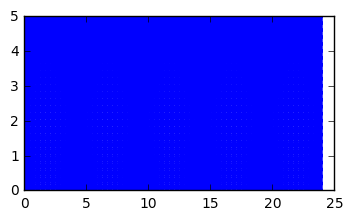

In [12]:
triang = tri.Triangulation(out.x,out.y,out.vols)
plt.figure(figsize=(4,2.25))
plt.triplot(triang)

Pcolor the topography

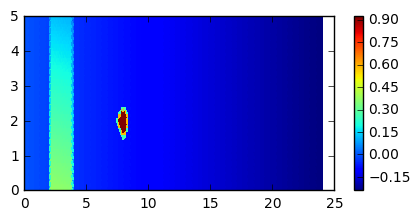

In [13]:
plt.figure(figsize=(4*1.25,2.25))
plt.tripcolor(triang,outc.elev)
plt.colorbar()

Pcolor multiple frames into one animation


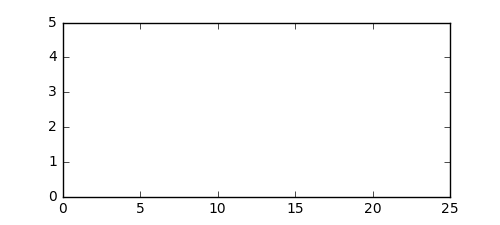
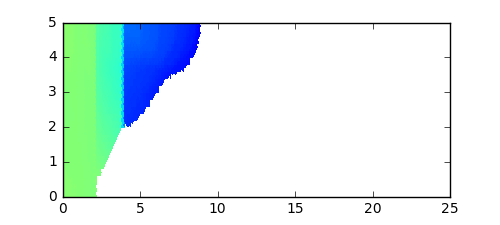
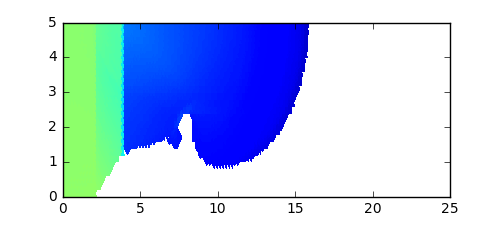
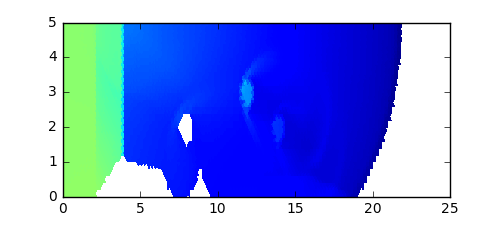
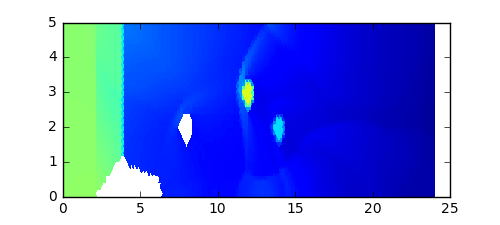
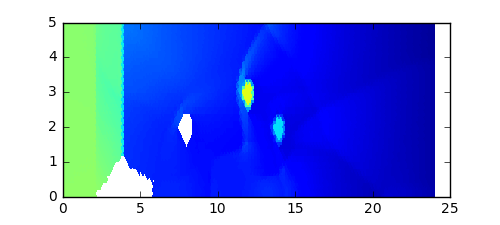
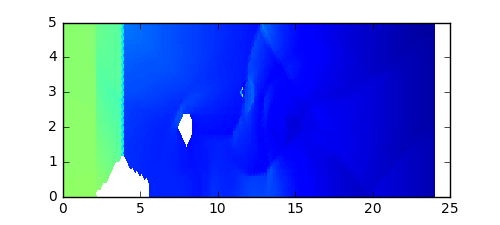
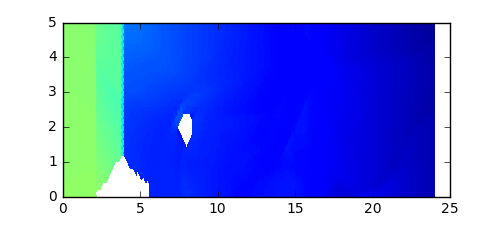
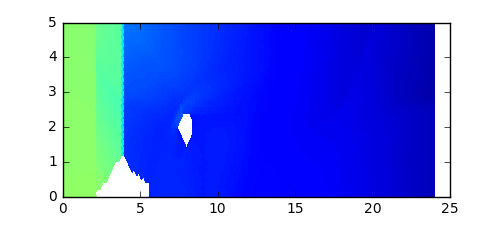
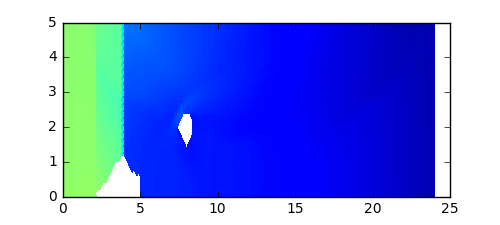

In [16]:
from JSAnimation import IPython_display
from matplotlib import animation

# create a simple animation
fig = plt.figure(figsize=(4*1.25,2.25))
ax = plt.subplot(111)
triang.set_mask(outc.stage[0,:]-outc.elev<=1e-5)
p = ax.tripcolor(triang, outc.stage[0,:],vmin=out.stage.min(),vmax=out.stage.max())

def animate(i):
    triang.set_mask(outc.stage[i*int(outc.stage.shape[0]/10.),:]-outc.elev<=1e-5)
    ax.tripcolor(triang,outc.stage[i*int(outc.stage.shape[0]/10.),:],vmin=out.stage.min(),vmax=out.stage.max())
    return p,

animation.FuncAnimation(fig, animate, frames=10, interval=200)

Obtain a profile view of the water at $y=2.0m$

In [18]:
tr = anuga.utilities.plot_utils.near_transect(out,[0,2.5],[40.0,2.0])

Sort values in ascending $x$ order.

In [19]:
tr = list(tr)
sorting = np.argsort(tr[1])
tr[1] = tr[1][sorting]
tr[0] = tr[0][sorting]

Check how the transect looks like

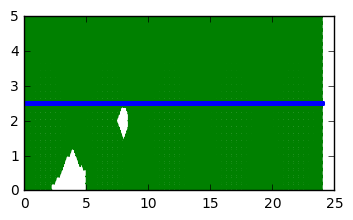

In [20]:
plt.figure(figsize=(4,2.25))
plt.plot(tr[1],np.ones_like(tr[1])*2.5,'.-')
plt.triplot(triang)

Animate these results


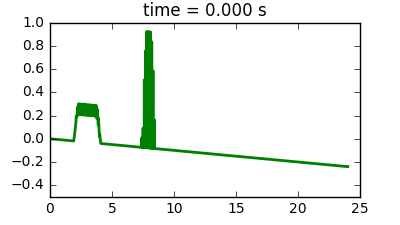
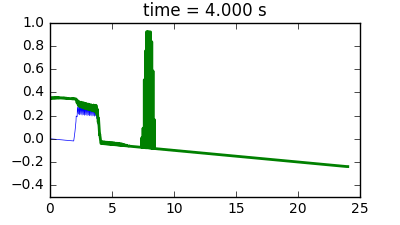
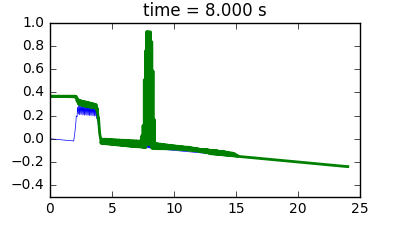
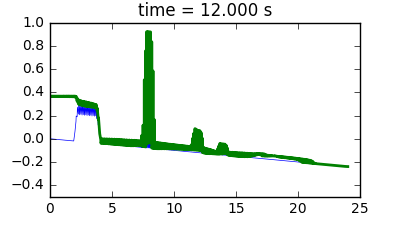
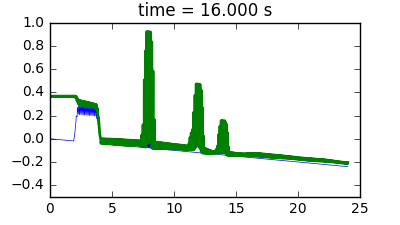
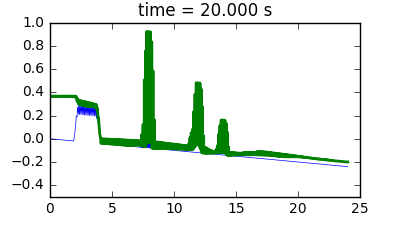
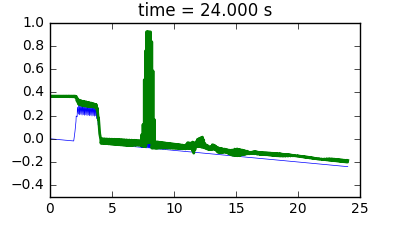
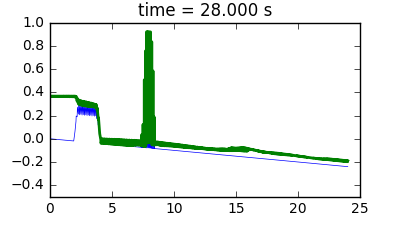
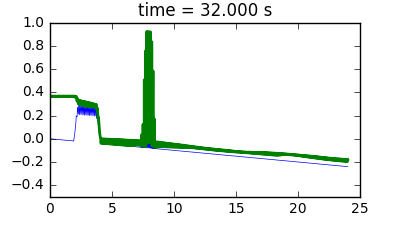
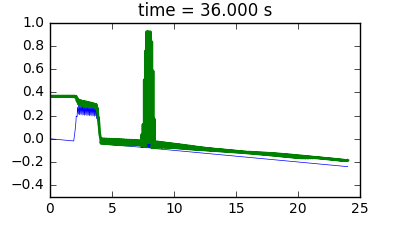

In [23]:
fig = plt.figure(figsize=(4,2.25))
ax = plt.subplot(111)
ax.plot(tr[1], out.elev[tr[0]],linewidth=0.5)
line, = ax.plot([], [], lw=2)
ttl = ax.set_title('time = 0.0 s')
ax.set_ylim(-0.5,1)
def animate(i):
    line.set_data(tr[1],out.stage[i*int(out.stage.shape[0]/10.),tr[0]])
    ttl.set_text('time = %.3f s'%out.time[i*int(out.stage.shape[0]/10.)])
    
    return line,

animation.FuncAnimation(fig, animate, frames=10, interval=200, blit=True)

## Check min height on results

In [24]:
np.where(out.height>0)

(array([  1,   1,   1, ..., 400, 400, 400]),
 array([   0,    1,    2, ..., 6143, 6144, 6145]))

In [25]:
out.height[np.where(out.height>0)].min()

0.00067255646

In [26]:
out.height[:,tr[0]][np.where(out.height[:,tr[0]]>1e-12)].min()

0.00067255646